## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
from joblib import dump, load
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import preprocessing as pp

/opt/miniconda3/envs/crystal_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training Functions

In [91]:
def dataset_split(features, labels_c, train_size=0.7, val_size=0.15):

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_c_tensor = torch.tensor(labels_c, dtype=torch.long)
    # labels_c_tensor = torch.tensor(labels_c, dtype=torch.float32)
    

    # Combine features and labels into a custom Dataset

    dataset = TensorDataset(features_tensor, labels_c_tensor)
    

    length = len(dataset)
    train_len = int(length * train_size)
    val_len = int(length * val_size)
    test_len = length - train_len - val_len

    train_data, val_data, test_data = torch.utils.data.random_split(
        dataset, [train_len, val_len, test_len])

    print(train_data)
    return train_data, val_data, test_data


def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


def plot_training_curve(train_loss, val_loss, train_accuracy, val_accuracy):
    plt.title("Train vs Validation Loss")
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    if train_accuracy != None: 
        plt.title("Train vs Validation Accuracy")
        plt.plot(train_accuracy, label="Train")
        plt.plot(val_accuracy, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()
        
        

## Classification Neural Net

In [37]:
[np.nan] * 10

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [73]:
def train_classification(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=30, checkpoints=True, plot=True):
    train_accuracies = []
    train_losses = []
    
    val_accuracies = []
    val_losses = []
    train_loader = DataLoader(train_data, batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()    
    
    ## train:
    total_train_samples = 0
    total_val_samples = 0
    all_train_preds, all_train_labels = [], []
    all_val_preds, all_val_labels = [], []
    start = time.time()
    
    for epoch in range(num_epochs):
        train_loss = 0.0 
        train_accuracy = 0.0
        
        for inputs, labels in train_loader: 
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1) ## returns (values, indices). we want to take the indices of the maximum probabilities along the class axis
            train_accuracy += (predicted != labels).sum().item()
            # print(predicted, labels)
            total_train_samples += len(labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            all_train_preds.extend(predicted.numpy())
            all_train_labels.extend(labels.numpy())
        
        train_loss /= len(train_loader)
        train_accuracy /= total_train_samples
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        

        with torch.no_grad():
            val_loss = 0.0 
            val_accuracy = 0.0
            for inputs, labels in val_loader:
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1) 
                val_accuracy += (predicted != labels).sum().item()
                total_val_samples += len(labels)
                        
            val_loss /= len(val_loader)
            val_accuracy /= total_val_samples
            
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            all_val_preds.extend(predicted.numpy())
            all_val_labels.extend(labels.numpy())
        
        if checkpoints:
            print(f"_______________________Epoch {epoch + 1}_______________________")

            print("Train loss: {} | Validation loss: {} ".format(
                train_losses[epoch],
                val_losses[epoch]
            ))
            print("Train acc: {} | Validation acc: {} ".format(
                train_accuracies[epoch],
                val_accuracies[epoch]
            ))

    if not checkpoints:
        print(f"_______________________Epoch {num_epochs}_______________________")

        print("Train loss: {} | Validation loss: {} ".format(
            train_losses[num_epochs-1],
            val_losses[num_epochs-1]
        ))
        print("Train acc: {} | Validation acc: {} ".format(
            train_accuracies[num_epochs-1],
            val_accuracies[num_epochs-1]
        ))

    print('Finished Training')
    elapsed_time = time.time() - start
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    train_conf_matrix = confusion_matrix(all_train_labels, all_train_preds)
    val_conf_matrix = confusion_matrix(all_val_labels, all_val_preds)
    
    if plot:
        plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return train_conf_matrix, val_conf_matrix
    

## Architecture

In [100]:
class my_network(nn.Module):
    def __init__(self, sz=[64, 100, 128], inp=20, out=3):
        super(my_network, self).__init__()
        self.layer_sizes = [inp] + sz + [out]
        self.name = "layer4linear"

        self.fc1 = nn.Linear(inp, sz[0])
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(sz[0], sz[1])
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(sz[1], sz[2])
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(sz[2], out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

    def get_number_params(self):
        num_params = 0
        for i in range(len(self.layer_sizes)-1):
            num_params += self.layer_sizes[i] * \
                self.layer_sizes[i+1] + self.layer_sizes[i+1]
        return num_params

test = my_network()
print(test.get_number_params())

21159


## Loading Data

In [6]:
my_path = '/Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/F_I_P_cubic'
my_loaded_data = pp.load_data(my_path)

>> Retrieving: F_I_P_cubic_labels_classification_space_1500.joblib
>> Retrieving: F_I_P_cubic_material_ids1500.joblib
>> Retrieving: F_I_P_cubic_labels_classification_system_1500.joblib
>> Retrieving: F_I_P_cubic_labels_classification_bravais_1500.joblib
>> Retrieving: F_I_P_cubic_regression_1500.joblib
>> Retrieving: F_I_P_cubic_features_1500.joblib
>> Sanity Check: printing element(s) 1 of 1500 from each array

[221]
[(MPID(mp-1008681), 'Sc')]
['Cubic']
['P']
[[2.96, 2.96, 2.96, 90.0, 90.0, 90.0]]
[[2.259, 4.518, 3.195, 2.259, 3.195, 0.0, 0.785, 0.786, 0.785, 2.259, 4.518, 3.913, 3.195, 3.913, 0.0, 0.955, 0.616, 0.615, 2.259, 4.518, 3.195, 2.259, 4.518, 0.0, 0.785, 0.786, 0.0, 2.259, 4.518, 3.913, 3.195, 3.913, 0.0, 0.955, 0.616, 0.615, 2.259, 4.518, 3.913, 3.195, 3.913, 0.0, 0.955, 0.616, 0.615, 2.259, 4.518, 3.195, 2.259, 4.518, 0.0, 0.785, 0.786, 0.0]]


In [10]:
my_loaded_data[3].count("P") == my_loaded_data[3].count("I") == my_loaded_data[3].count("F") == 500

True

### Converting Labels to One Hot Encoding

In [14]:
features_vectors = my_loaded_data[-1]
len(features_vectors[0]) ## (5 + 4) * 6

54

In [16]:
# 'Simple (P)', 'Body centered (I)', 'Face centered (F)'

dict_encode = {
    'P': 0,
    'I': 1,
    'F': 2
}

labels_encoded = [dict_encode[y] for y in my_loaded_data[3]]

In [20]:
labels_encoded.count(0) == labels_encoded.count(1) == labels_encoded.count(2) == 500

True

### Converting Data to Tensors

In [31]:
train_data, val_data, test_data= dataset_split(
                                            features=features_vectors,
                                            labels_c=labels_encoded
                                            )

## Training

_______________________Epoch 1_______________________
Train loss: 1.1099888704942935 | Validation loss: 1.089544547015223 
Train acc: 0.66 | Validation acc: 0.6044444444444445 
_______________________Epoch 2_______________________
Train loss: 1.0920492469361334 | Validation loss: 1.0813886995973259 
Train acc: 0.3161904761904762 | Validation acc: 0.3 
_______________________Epoch 3_______________________
Train loss: 1.0740774323542912 | Validation loss: 1.1003897724480465 
Train acc: 0.1946031746031746 | Validation acc: 0.2088888888888889 
_______________________Epoch 4_______________________
Train loss: 1.0502199715737142 | Validation loss: 1.0722568569512203 
Train acc: 0.13595238095238096 | Validation acc: 0.13555555555555557 
_______________________Epoch 5_______________________
Train loss: 1.0571881329471415 | Validation loss: 1.0362057069252277 
Train acc: 0.11047619047619048 | Validation acc: 0.10666666666666667 
_______________________Epoch 6_______________________
Train loss: 

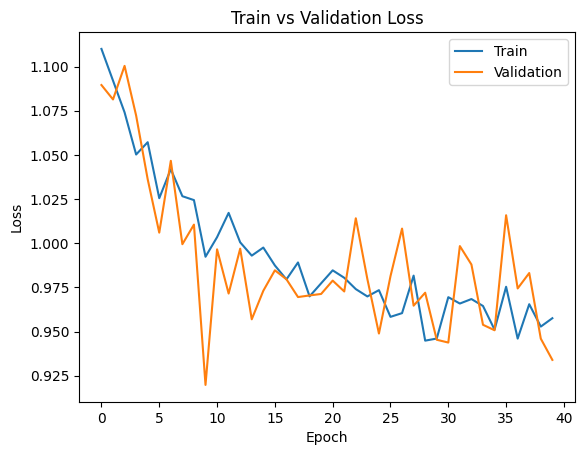

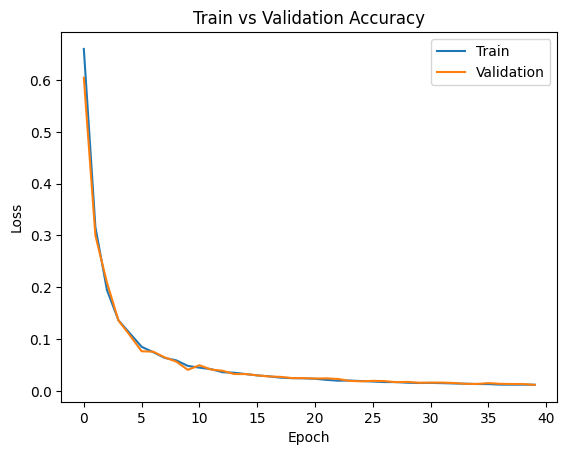

In [74]:
model = my_network()

train_conf, val_conf = train_classification(
                  model, 
                  train_data, 
                  val_data,
                  batch_size=8, 
                  learning_rate=0.001, 
                  num_epochs=40, 
                  checkpoints=True
                  )

42000


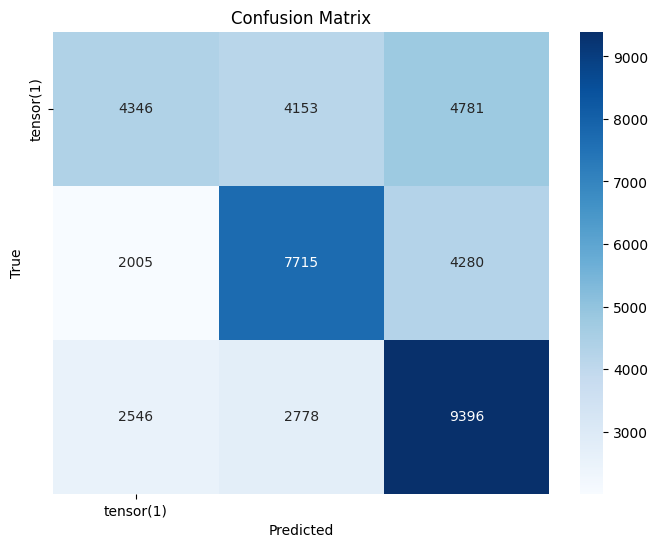

In [75]:
print(sum(sum(train_conf)))
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [71]:
(4484 + 7054 + 9657)/42000

0.5046428571428572

In [72]:
model.eval()

test_loss = 0.0
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()

gt_list = []
preds_list = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data

        outputs = model(inputs)
        
        
        
        
        gt_list.append(labels.tolist())
        

        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1) ## returns (values, indices). we want to take the indices of the maximum probabilities along the class axis
        preds_list.append(outputs.tolist())
        print(outputs)
        print(labels)
        print(predicted)
        
# val_accuracy += (predicted != labels).sum().item()
        
test_loss /= len(test_data)
print(f'Test Loss: {test_loss}')



# percent_diffs = []
# for i in range(len(gt_list)):
#     for j in range(len(gt_list[i])):
#         GT = round(gt_list[i][j][0], 2)
#         PD = round(preds_list[i][j][0], 2)
#         DIFF = round(GT - PD, 2)
#         PDIFF = round(abs(GT - PD) / GT * 100, 2)
#         percent_diffs.append(PDIFF)
        
#         print(f"GT: {GT:>5.2f}    PD: {PD:>5.2f}    DIFF: {DIFF:>5.2f}    %DIFF: {PDIFF:>5.2f}%")

# Acceptable % difference <= 10%

#percent_diffs = np.array(percent_diffs)

# beam directions 
# classifications
# monoclinic (7 > )
# thurs 

tensor([[ 0.0130,  0.3202, -0.6058],
        [-0.1185,  0.4104, -0.6921],
        [-0.2468,  0.6649, -1.0995],
        [ 0.2100, -0.3559,  0.0737],
        [-0.1090,  0.2914, -0.4758],
        [ 0.2679, -0.4254,  0.0788],
        [-0.2018, -0.4253,  0.4346],
        [ 0.0756, -0.0886, -0.0813],
        [ 0.1772,  0.6824, -1.4026],
        [ 0.0866, -0.2262,  0.0759],
        [ 0.3199, -0.3360, -0.1365],
        [-0.3511, -0.6810,  0.6840],
        [-0.2992, -0.5578,  0.5718],
        [ 0.2483, -0.3563,  0.0235],
        [-0.2939, -0.6769,  0.6573],
        [-0.4219, -0.7624,  0.7741],
        [-0.2313, -0.3814,  0.4094],
        [-0.4155, -0.6787,  0.7116],
        [-0.3497,  0.3975, -0.5930],
        [ 0.0063,  0.1449, -0.3335],
        [ 0.0110,  0.0166, -0.1543],
        [ 0.2938, -0.4861,  0.1101],
        [ 0.2965, -0.4664,  0.0850],
        [-0.1629,  0.3987, -0.6454],
        [ 0.5804, -0.7342, -0.0915],
        [-0.0427, -0.6134,  0.4818],
        [ 0.0453,  0.0555, -0.2706],
 

In [98]:
my_path = '/Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/F_I_P_cubic_x_y'
my_loaded_data = pp.load_data(my_path)
print(my_loaded_data[1].count("P") == my_loaded_data[1].count("I") == my_loaded_data[1].count("F") == 500)

features_vectors = my_loaded_data[4]
print(len(features_vectors[0])) ## (5 + 4) * 6

# 'Simple (P)', 'Body centered (I)', 'Face centered (F)'

# 'Simple (P)', 'Body centered (I)', 'Face centered (F)'

dict_encode = {
    'P': 0,
    'I': 1,
    'F': 2
}

labels_encoded = [dict_encode[y] for y in my_loaded_data[1]]


>> Retrieving: F_I_P_cubic_x_y_regression_1500.joblib
>> Retrieving: F_I_P_cubic_x_y_labels_classification_bravais_1500.joblib
>> Retrieving: F_I_P_cubic_x_y_material_ids1500.joblib
>> Retrieving: F_I_P_cubic_x_y_labels_classification_system_1500.joblib
>> Retrieving: F_I_P_cubic_x_y_features_1500.joblib
>> Retrieving: F_I_P_cubic_x_y_labels_classification_space_1500.joblib
>> Sanity Check: printing element(s) 1 of 1500 from each array

[[3.97, 3.97, 3.97, 90.0, 90.0, 90.0]]
['P']
[(MPID(mp-1007693), 'HfOs3')]
['Cubic']
[[0.0, 3.363, 3.363, -0.0, -0.0, -3.363, -3.363, 0.0, 3.363, 3.363, 3.363, -3.363, -3.363, -3.363, -3.363, 3.363, -6.726, 0.0, -0.0, -6.726]]
[221]
True
20


_______________________Epoch 1_______________________
Train loss: 1.1232994076880543 | Validation loss: 1.1355922222137451 
Train acc: 0.6876190476190476 | Validation acc: 0.6844444444444444 
_______________________Epoch 2_______________________
Train loss: 1.1051814226490078 | Validation loss: 1.1111784104643196 
Train acc: 0.3219047619047619 | Validation acc: 0.32 
_______________________Epoch 3_______________________
Train loss: 1.1095993821368073 | Validation loss: 1.0865298715131035 
Train acc: 0.21682539682539684 | Validation acc: 0.2 
_______________________Epoch 4_______________________
Train loss: 1.10648448945898 | Validation loss: 1.0875298483618374 
Train acc: 0.16285714285714287 | Validation acc: 0.15666666666666668 
_______________________Epoch 5_______________________
Train loss: 1.0923131550803329 | Validation loss: 1.0919927913567116 
Train acc: 0.12647619047619046 | Validation acc: 0.12711111111111112 
_______________________Epoch 6_______________________
Train loss: 

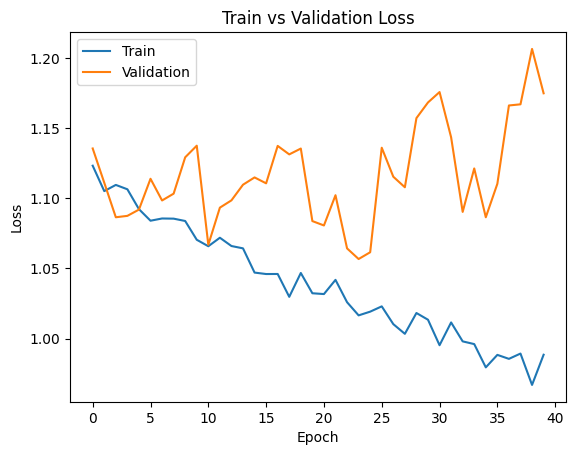

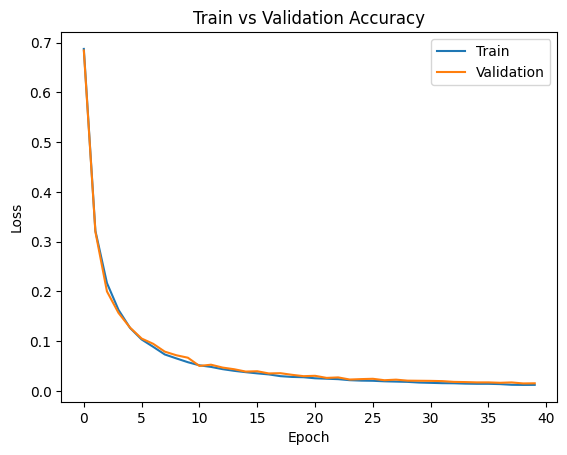

In [101]:
train_data, val_data, test_data= dataset_split(
                                            features=features_vectors,
                                            labels_c=labels_encoded
                                            )



model = my_network()

train_conf, val_conf = train_classification(
                  model, 
                  train_data, 
                  val_data,
                  batch_size=8, 
                  learning_rate=0.001, 
                  num_epochs=40, 
                  checkpoints=True
                  )

42000


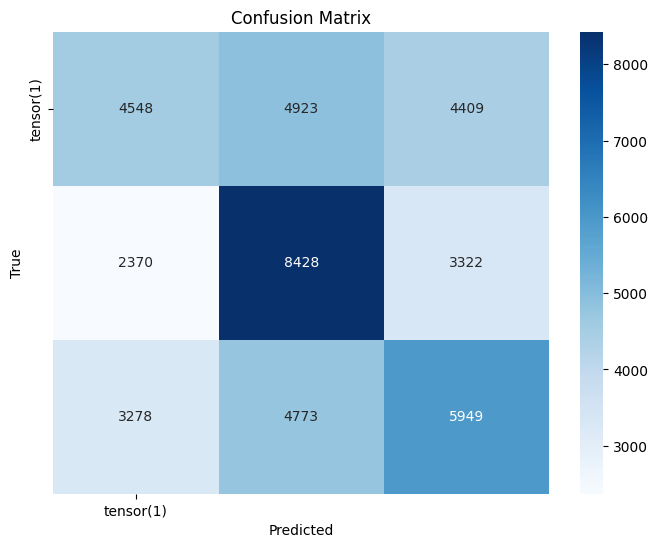

In [102]:
print(sum(sum(train_conf)))
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()